# Run Spark locally

In [42]:
from pyspark.sql import SparkSession
import os
    
# get ip address of master node (current machine)
ip = os.popen('hostname -i').read().strip('\n')

spark = SparkSession.builder \
    .master('local[28]') \
    .appName('review') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

Spark Session web UI: http://10.50.221.36:4040


Load data

In [43]:
df = spark.read.json('/project/cmsc25025/beer_review/labeled.json')
print type(df)
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|overall|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   3.0|On tap at the Spr...|        0|   17|  6.0|
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   4.0|On tap at the Joh...|        1|   17|  7.0|
|       4.0|  5.0|  95213|John Harvards Cri...|  3084|   14.0|   3.0|UPDATED: FEB 19, ...|        2|   33|  6.0|
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|    8.0|   2.0|On tap the Spring...|        3|   33|  4.0|
|       5.0|  8.0|  41336|John Harvards Van...|  3084|   16.0|   4.0|Springfield, PA l...|        5|   58|  7.0|
|       4.0|  5.0|  80424|John Harvards Ame...|  3084|

# Part 1: Data inspection

In [44]:
import numpy as np
import pandas as pd
def mean_value(x):
    np.array(list(x))
    return mean_value

id_overall = df.rdd.map(lambda x: (x['beer_id'],x['overall']))
brewer_overall = df.rdd.map(lambda x: (x['brewer'],x['overall']))
num_review = id_overall.count()

id_rate = id_overall.groupByKey().mapValues(list).map(lambda x: (x[0],np.mean(np.array(x[1])),np.median(np.array(x[1])),np.std(np.array(x[1]))))
brewer_rate = brewer_overall.groupByKey().mapValues(list).map(lambda x: (x[0],np.mean(np.array(x[1])),np.median(np.array(x[1])),np.std(np.array(x[1]))))
print pd.DataFrame(id_rate.take(10), columns = ['beer_id', 'mean', 'median', 'std']).sort_values('beer_id')
print '\n\n'
print pd.DataFrame(brewer_rate.take(10), columns = ['brewer_id', 'mean', 'median', 'std']).sort_values('brewer_id')

   beer_id       mean  median       std
0        0  11.000000    10.0  2.160247
5     8204  15.416667    15.0  1.497683
8    16408  12.200000    12.0  0.748331
1    28672  12.166667    12.5  1.343710
7    32788  15.000000    15.0  1.000000
2    40964  15.500000    15.5  0.500000
9    69636  16.500000    16.5  0.500000
4    80556  13.000000    13.0  0.000000
3    81928  13.000000    13.0  0.000000
6   106512  10.666667    10.0  0.942809



   brewer_id       mean  median       std
0          0  12.836224    13.0  2.543297
7       1036  13.571429    14.0  1.399708
6       1708   2.500000     2.5  0.500000
9       2576   9.307692    10.0  2.266295
5       3080  10.904762    11.0  2.307436
1       3584  11.278523    12.0  3.034413
8       3780  14.000000    14.0  0.000000
4       3836  12.652574    13.0  2.385363
2       4228   9.333333    11.0  3.771236
3       5124  13.591779    14.0  2.415351


In [38]:
print 'The mean for overall ratings:'
print df.rdd.map(lambda x: x['overall']).mean()
print '\nThe stdev for overall ratings:'
print df.rdd.map(lambda x: x['overall']).stdev()

The mean for overall ratings:
13.1988796419

The stdev for overall ratings:
3.35235080917


judge the similarity of people's tastes by the variance of reviews

In [39]:
from __future__ import division
total_id = id_rate.count()
id_std_small = id_rate.filter(lambda x: x[3]<=3).count() / total_id
total_brewer= brewer_rate.count()
brewer_std_small = brewer_rate.filter(lambda x: x[3] < 3).count() / total_brewer

In [40]:
print id_std_small
print brewer_std_small

0.938937328931
0.849432197729


From the calculations above, the variance of reviews for most beer ids and beer brewers are small ( e.g., std < 3), based on the stdev for overall rating, thus we can conclude that people have similar taste.

# Part 2: Sentiment analysis

## (1) Generating features

Get label and review

In [45]:
# clean review text
import string

# convert overall score to binary label
def binary_label(overall):
    """
    Get the binary label from overall score
    """
    return (1 if overall>= 14 else 0)

#clean text
import re
def clean_text(review):
    #Extract pool of words from the review 
    text=review.encode('ascii','ignore')
    body_txt= re.sub('(<.*?>)','',text)
    body_txt= re.sub('(,*)','',body_txt)
    body_txt= re.sub('\n'," ",body_txt)
    body_txt= re.sub('[( )]',' ',body_txt)
    body_txt= re.sub('\s+', ' ',body_txt)
    body_txt= re.sub('& .', ' ',body_txt)
    body_txt= re.sub('[.+ - * /]', ' ',body_txt)
    body_txt= re.sub('[-]', ' ',body_txt)
    body_txt = body_txt.replace("@"," ")
    body_txt = body_txt.replace("%"," ")
    body_txt = body_txt.replace(":"," ")
    body_txt=body_txt.lower()
    body_txt=''.join([i for i in body_txt if not i.isdigit()])
    body_txt=body_txt.split(' ')
    body_txt= [w for w in body_txt if w != '']
    return body_txt

#label_review = df.rdd.map(lambda x: (binary_label(x['overall']), clean_text(x['review'])))
#review = df.rdd.map(lambda x: clean_text(x['review']))

read vocabulary from vacab_50.json ( the most common 50 words were thrown out)

In [46]:
import json
with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
    vocab = json.load(f)
print type(vocab)
voc_size = len(vocab)
print voc_size
print vocab.keys()[:10]

<type 'dict'>
30009
[u'fawn', u'woods', u'spiders', u'hanging', u'woody', u'spidery', u'canes', u'gteborg', u'originality', u'bocky']


create feature vector for each review

In [47]:
from pyspark.mllib.linalg import SparseVector

# add label and map to feature for each review

# need to double check this feature vector calculation function
def map_feature(review, voc):
    j = 0
    nonzero_index = []
    for key in voc.iterkeys():
        if key in review:
            nonzero_index.append(j)
        else:
            pass
        j+=1
    list_size = len(nonzero_index)
    list_index = np.array(nonzero_index)
    return SparseVector(len(vocab), nonzero_index, np.ones(list_size))

def preprocess(x, vocab):
    label = binary_label(x['overall'])
    text = clean_text(x['review'])
    feature = map_feature(text, vocab)
    return (label, feature)

label_feature = df.rdd.map(lambda x: preprocess(x, vocab))
first = label_feature.take(1)
print first



[(0, SparseVector(30009, {645: 1.0, 959: 1.0, 1721: 1.0, 2817: 1.0, 3319: 1.0, 3785: 1.0, 5196: 1.0, 5501: 1.0, 5948: 1.0, 7974: 1.0, 8581: 1.0, 10934: 1.0, 12512: 1.0, 13886: 1.0, 14259: 1.0, 14562: 1.0, 15639: 1.0, 15892: 1.0, 16390: 1.0, 19631: 1.0, 19661: 1.0, 19921: 1.0, 20573: 1.0, 20973: 1.0, 21345: 1.0, 21968: 1.0, 22377: 1.0, 23347: 1.0, 23650: 1.0, 24054: 1.0, 25369: 1.0, 26426: 1.0, 27600: 1.0}))]


zip lab and feature vector for each review

split data to training, validation, testing sets with proportion 0.7:0.15:0.15

In [48]:
train, dev, test = df.rdd.randomSplit([0.7, 0.15, 0.15])
print 'Sizes of training data and dev/test data are %d and %d.' % (train.count(), dev.count())
batch_df = train.sample(False, 1e-4)
batch_size = batch_df.count()
print 'Batch_size is %d.' % batch_size
batch = batch_df.map(lambda x: preprocess(x, vocab))
batch.take(1)

Sizes of training data and dev/test data are 1740287 and 373735.
Batch_size is 190.


[(0,
  SparseVector(30009, {4: 1.0, 254: 1.0, 2142: 1.0, 5077: 1.0, 8909: 1.0, 9043: 1.0, 10331: 1.0, 10596: 1.0, 14562: 1.0, 14724: 1.0, 16853: 1.0, 18532: 1.0, 18983: 1.0, 20028: 1.0, 20126: 1.0, 20239: 1.0, 21542: 1.0, 22778: 1.0, 27140: 1.0, 27600: 1.0, 28621: 1.0, 29882: 1.0}))]

In [84]:
import math

def logit(x, beta):
    # cal_y_hat
    return 1.0 / (1 + np.exp(-beta.dot(x)))
def predict_error(x,beta,y):
    # get the total number of wrong predictions
    return 0 if np.absolute(y-logit(x,beta.T))<0.5 else 1
def neg_log_likelihood(x, beta, y):
    # get the negative log likelihood
    betax = beta.dot(x)
    nll = -y * betax + np.log(1 + np.exp(betax))
    return nll[0]
def get_error_rate(df_lf, beta, ct):
    # Calculate average error rate and negative log likelihood
    errors = df_lf.map(lambda x: predict_error(x[1], beta, x[0])).reduce(lambda a, b: a+b)
    nlog_likelihood = df_lf.map(lambda x: neg_log_likelihood(x[1], beta.T, x[0])).reduce(lambda a, b: a+b)
    return (nlog_likelihood/ct, errors/ct)
def logit_sgd(eta0, l2, max_iter, dev_lf, dev_size):
    # Perform SGD logistic regression
    beta = np.zeros((voc_size, 1))
    overall = []
    print 'Iteration#\tneg_log_likelihood(train)\tError_rate(train)\tneg_log_likelihood(dev)\tError_rate(dev)\n'
    for i in range(1, max_iter):
        eta = eta0 / math.sqrt(i)
        train_sample = train.sample(False, 1e-4)
        if i == 1:
            train_size = train_sample.count()
        batch_df = train_sample.map(lambda x: preprocess(x, vocab))
        grad = batch_df.map(lambda x: eta * (x[0] - logit(x[1], beta.T)) * x[1]).reduce(lambda a, b:a+b).reshape((voc_size, 1))
        beta += grad - l2 * beta
        train_nll, train_error_rate = get_error_rate(batch_df, beta, np.float(train_size))
        dev_nll, dev_error_rate = get_error_rate(dev_lf, beta, np.float(dev_size))
        overall.append([i, train_nll, train_error_rate, dev_nll, dev_error_rate])
        #print '%d\t%.02f\t%.02f\t%.02f\t%.02f' % tuple(overall[-1])
        print overall[-1]
    return overall, beta

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

def plt_iterations(overall, beta):    
    #plot negative log-likelihood and error error of train and develop data set as a function of iterations 
    overall = np.array(overall)
    iterations = overall[:, 0]
    tr_nll = overall[:, 1]
    tr_error_rate = overall[:, 2]
    dev_nll = overall[:, 3]
    dev_error_rate = overall[:, 4]
    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(iterations, tr_nll, 'ro--', label='train')
    plt.legend()
    plt.plot(iterations, dev_nll, 'bo--', label='dev')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Negative loglikelihood')
    plt.subplot(1,2,2)
    plt.plot(iterations, tr_error_rate, 'r>--', label='train')
    plt.legend()
    plt.plot(iterations, dev_error_rate, 'b>--', label='dev')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Error rate')
    plt.show()
#plt_iterations(relax, beta)

## --> Fix penalty parameter (lambda), looking for best learning rate (eta)
### lambda = 0.05, eta = 1/sqrt(t)

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.38538157042354448, 0.1366120218579235, 2.3082814995986416, 0.40625]
[2, 0.9883516551754209, 0.18032786885245902, 2.2582361809555453, 0.375]
[3, 5.9700558680048674, 0.3333333333333333, 9.4736235613737172, 0.50625]
[4, 5.6891000985830802, 0.3989071038251366, 7.011489269998596, 0.425]
[5, 5.0352870828242322, 0.3551912568306011, 7.0826782559117971, 0.45]
[6, 3.9700113934511077, 0.3333333333333333, 6.0616725035927814, 0.40625]
[7, 5.6150661966471027, 0.3551912568306011, 6.0782002839995481, 0.40625]
[8, 2.0980953579155841, 0.2677595628415301, 3.6043489036117373, 0.36875]
[9, 1.3974105896042828, 0.21311475409836064, 3.405543617757421, 0.3625]
[10, 0.88181413175328194, 0.22950819672131148, 2.7321089790541491, 0.39375]
[11, 0.56446830804865478, 0.16393442622950818, 2.2795961189549323, 0.3625]
[12, 0.5845449231272003, 0.2185792349726776, 2.1991452411261836, 0.35]
[13, 1.0316555587796354, 0.24590

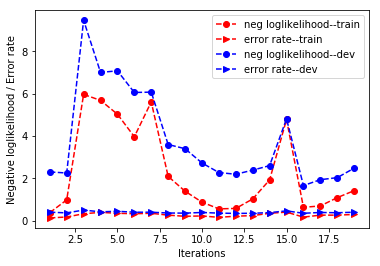

In [81]:
dev_sample = dev.sample(False, 5 * 1e-4)
dev_lf = dev_sample.map(lambda x: preprocess(x, vocab))
dev_size = dev_sample.count()
eta0 = 1
l2 = 0.05
max_iter = 20
relax, beta = logit_sgd(eta0, l2, max_iter, dev_lf, dev_size)
plt_iterations(relax, beta)


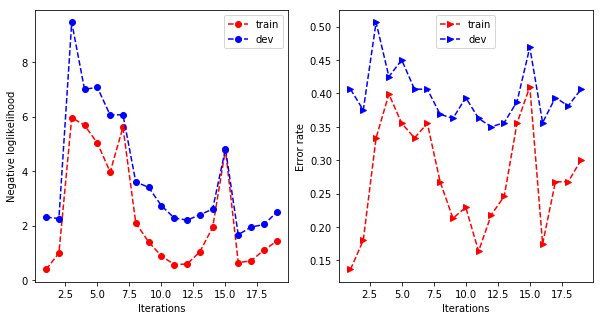

In [91]:
plt_iterations(relax, beta)

### lambda = 0.05, eta = 0.1 / sqrt(t)

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.53669822578581117, 0.3132530120481928, 1.1927589742006566, 0.5]
[2, 0.82831683320680749, 0.4578313253012048, 0.82228696059031792, 0.40625]
[3, 0.77565854545121216, 0.3614457831325301, 0.86895642773813064, 0.45625]
[4, 0.46803312608843078, 0.1927710843373494, 0.59472772402219198, 0.31875]
[5, 0.41228157582675035, 0.16265060240963855, 0.60768602611402855, 0.325]
[6, 0.37617819113796447, 0.14457831325301204, 0.58613608152448105, 0.28125]
[7, 0.51718807945739464, 0.23493975903614459, 0.63734826490644803, 0.36875]
[8, 0.50774147681240023, 0.20481927710843373, 0.56413586690087425, 0.28125]
[9, 0.47831346287643001, 0.2289156626506024, 0.63935708040197192, 0.35625]
[10, 0.42036800500792865, 0.16265060240963855, 0.57664282005495981, 0.3]
[11, 0.46747066218724792, 0.19879518072289157, 0.56876422197610166, 0.29375]
[12, 0.44186080355091883, 0.16265060240963855, 0.56140292422604543, 0.30625]
[13, 

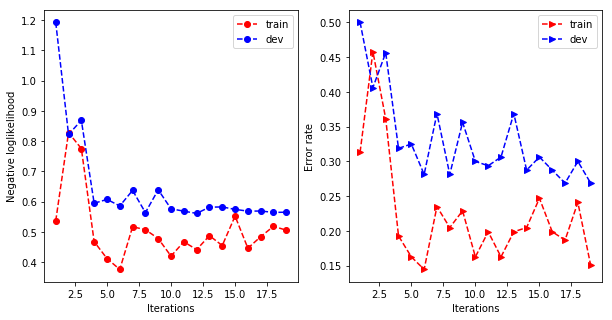

In [92]:
eta0 = 0.1
l2 = 0.05
max_iter = 20
relax, beta = logit_sgd(eta0, l2, max_iter, dev_lf, dev_size)
plt_iterations(relax, beta)


### lambda = 0.05, eta = 0.01 / sqrt(t)

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.62379449360934525, 0.2275449101796407, 0.67664736220579336, 0.46875]
[2, 0.66740748637373182, 0.33532934131736525, 0.66879902801956492, 0.425]
[3, 0.68870151601730434, 0.39520958083832336, 0.66610443992198687, 0.4625]
[4, 0.65358098439571199, 0.38323353293413176, 0.66028804451759282, 0.43125]
[5, 0.74281480210298589, 0.38323353293413176, 0.65628848546384888, 0.425]
[6, 0.57236934097791592, 0.30538922155688625, 0.65389813867686331, 0.40625]
[7, 0.6644733477076683, 0.3413173652694611, 0.6495066204125205, 0.35625]
[8, 0.62413309458367972, 0.2934131736526946, 0.64895884289487227, 0.36875]
[9, 0.65254596197769754, 0.3592814371257485, 0.64649731471932559, 0.3375]
[10, 0.60053763274671135, 0.3413173652694611, 0.64620681652566447, 0.34375]
[11, 0.63223585972737373, 0.281437125748503, 0.64480959537977678, 0.30625]
[12, 0.65898938461500978, 0.31137724550898205, 0.64323520099569076, 0.30625]
[13,

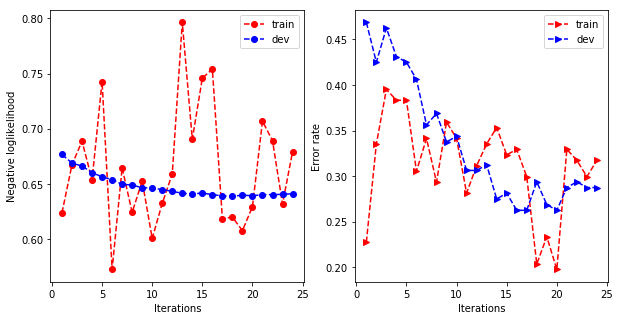

In [94]:
eta0 = 0.01
l2 = 0.05
max_iter = 25
relax, beta = logit_sgd(eta0, l2, max_iter, dev_lf, dev_size)
plt_iterations(relax, beta)


From the above three iterations with learning rate 1/sqrt(t), 0.1/sqrt(t), 0.01/sqrt(t), we observe that when that large learning rate impedes the convergence (the nagative log likelihood and error rate oscillate too much), while small learning rate makes convengence too slow. Here we choose an intermediate learning rate, which is 0.1/sqrt(t).

## --> Fix learning rate at 0.1 / sqrt(t), look at the effect of lambda

### lambda = 0.1

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.39978610826691646, 0.2185430463576159, 0.85762197859861722, 0.525]
[2, 1.1169920317552684, 0.5894039735099338, 1.054886655873335, 0.45]
[3, 0.67715479862213857, 0.36423841059602646, 0.76530378337681937, 0.4125]
[4, 0.53005468315610105, 0.2185430463576159, 0.66459831236370559, 0.35]
[5, 0.68018479501461249, 0.36423841059602646, 0.79509829186465797, 0.425]
[6, 0.81046690612509886, 0.41721854304635764, 0.76347586215261598, 0.3875]
[7, 0.73059024121151628, 0.37748344370860926, 0.68214236089200841, 0.3625]
[8, 0.48976763242004284, 0.2052980132450331, 0.58887307026490432, 0.31875]
[9, 0.41594091412379691, 0.11920529801324503, 0.58174701947673046, 0.30625]
[10, 0.50424665818205028, 0.18543046357615894, 0.57634401983279948, 0.30625]
[11, 0.49912739912955406, 0.19205298013245034, 0.56854616055247598, 0.25625]
[12, 0.50735278304981135, 0.1456953642384106, 0.56729881403534355, 0.30625]
[13, 0.552

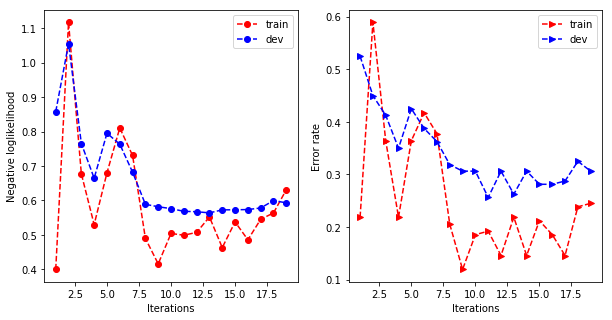

In [96]:
eta0 = 0.1
l2 = 0.1
max_iter = 20
relax, beta = logit_sgd(eta0, l2, max_iter, dev_lf, dev_size)
plt_iterations(relax, beta)


In [109]:
relax = np.array(relax)
#print np.mean(relax[13:, [2,4]], axis=0)
regulation = [[0.05, 0.203958692, 0.298214286]]
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())
#print regulation


[ 0.19536424  0.29791667]
[[0.05, 0.203958692, 0.298214286], [0.1, 0.19536423841059603, 0.29791666666666666]]


### lambda = 0.001

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.36825879271513168, 0.1638418079096045, 0.76688410375155214, 0.45]
[2, 0.57133413929575017, 0.2994350282485876, 0.81705447830012479, 0.40625]
[3, 0.65310022651506083, 0.2994350282485876, 0.88950051083595505, 0.45625]
[4, 0.33839104476639087, 0.12429378531073447, 0.56044417414374337, 0.3]
[5, 0.35721700566142189, 0.12994350282485875, 0.55248862294476042, 0.31875]
[6, 0.37533515048915844, 0.1694915254237288, 0.57451357232049549, 0.35625]
[7, 0.38295438065569504, 0.20903954802259886, 0.59255484935082692, 0.30625]
[8, 0.46768726633749447, 0.21468926553672316, 0.55709717072621667, 0.33125]
[9, 0.39325997298589471, 0.15819209039548024, 0.54923211222103219, 0.325]
[10, 0.42849361700756533, 0.15819209039548024, 0.54703159600313533, 0.3375]
[11, 0.45504589476649748, 0.21468926553672316, 0.55426798276240818, 0.34375]
[12, 0.3735270837811327, 0.13559322033898305, 0.54744626292809873, 0.33125]
[13,

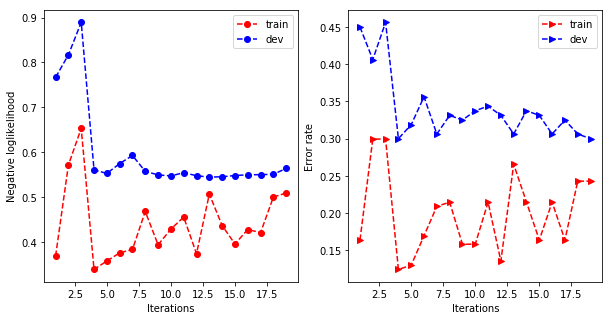

In [110]:
eta0 = 0.1
l2 = 0.001
max_iter = 20
relax, beta = logit_sgd(eta0, l2, max_iter, dev_lf, dev_size)
plt_iterations(relax, beta)
relax = np.array(relax)
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())

### lambda = 0.5

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.3899765329005106, 0.19375, 0.8087205798027528, 0.50625]
[2, 0.64899527687950964, 0.28125, 0.66715011838548066, 0.39375]
[3, 0.8316300207561238, 0.46875, 1.0262377498291477, 0.5375]
[4, 1.3741711663011829, 0.65, 1.0965780018229336, 0.48125]
[5, 1.1979665701315358, 0.48125, 1.2221773802429339, 0.5375]
[6, 0.84138527243385131, 0.4625, 0.86164860948668553, 0.4625]
[7, 0.92304851729298343, 0.51875, 0.86292698535573165, 0.53125]
[8, 0.80373159203599154, 0.46875, 0.86487709548118819, 0.4625]
[9, 0.71747259564638932, 0.475, 0.82885316755181671, 0.53125]
[10, 0.68397878581523597, 0.41875, 0.75094662863526751, 0.45625]
[11, 0.66079547610145217, 0.46875, 0.67508661496963662, 0.45625]
[12, 0.54525619635268041, 0.15, 0.63756350834614062, 0.30625]
[13, 0.63832215560242611, 0.38125, 0.66972601864230275, 0.48125]
[14, 0.6153666169689157, 0.38125, 0.7037218755303043, 0.40625]
[15, 0.67089454496099177, 

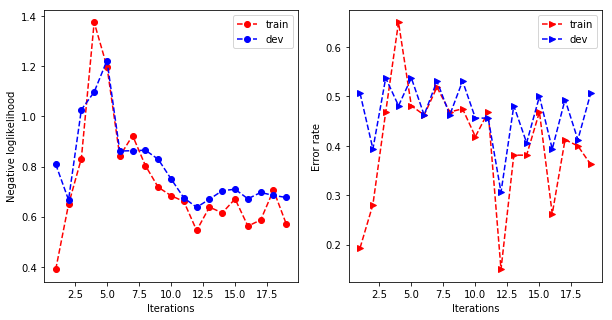

In [117]:
eta0 = 0.1
l2 = 0.5
max_iter = 20
relax, beta = logit_sgd(eta0, l2, max_iter, dev_lf, dev_size)
plt_iterations(relax, beta)
relax = np.array(relax)
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())

### lambda = 0

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.34943190131252611, 0.1524390243902439, 0.7396317809620554, 0.4125]
[2, 1.1542503427838144, 0.5060975609756098, 1.2353274329516424, 0.45625]
[3, 0.60146561194222037, 0.34146341463414637, 0.91852363794184022, 0.425]
[4, 0.36935695166812071, 0.14634146341463414, 0.60103086603110889, 0.325]
[5, 0.41595748345125438, 0.1951219512195122, 0.57990092100727186, 0.275]
[6, 0.40243700000971599, 0.12195121951219512, 0.59065321879385768, 0.3]
[7, 0.56759284540708799, 0.2621951219512195, 0.58810867955111723, 0.2875]
[8, 0.37806196242406553, 0.17073170731707318, 0.57471513103129346, 0.25]
[9, 0.4407187939967262, 0.1951219512195122, 0.57715431995569721, 0.28125]
[10, 0.41409924973426743, 0.15853658536585366, 0.56750861479095072, 0.25625]
[11, 0.49180159286904068, 0.24390243902439024, 0.55946859185015752, 0.24375]
[12, 0.51783545602170677, 0.24390243902439024, 0.56229651603604913, 0.25625]
[13, 0.467173

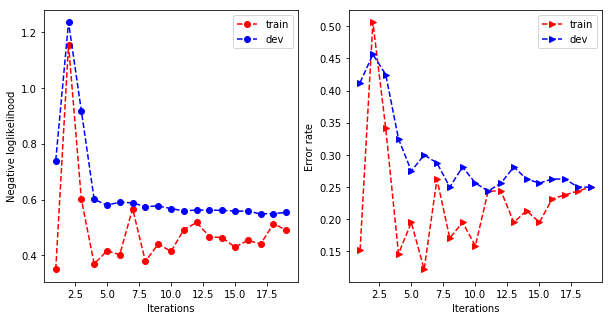

In [170]:
eta0 = 0.1
l2 = 0
max_iter = 20
relax, beta = logit_sgd(eta0, l2, max_iter, dev_lf, dev_size)
plt_iterations(relax, beta)
relax = np.array(relax)
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())

lambda, error rate for training date, error rate for develop data:
[0.05, 0.203958692, 0.298214286]
[0.1, 0.19536423841059603, 0.29791666666666666]
[0.001, 0.20715630885122407, 0.31770833333333337]
[0.5, 0.3812499999999999, 0.4520833333333334]
[0, 0.16666666666666666, 0.28020833333333334]


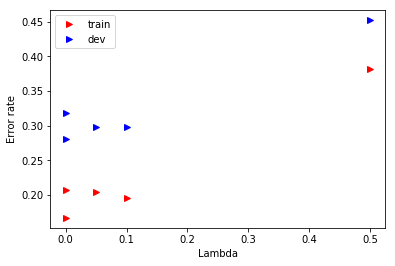

In [131]:
print 'lambda, error rate for training date, error rate for develop data:'
for line in regulation:
    print line
def plot_lambda(x):
    x = np.array(x)
    lambdas = x[:, 0]
    tr_error_rate = x[:, 1]
    dev_error_rate = x[:, 2]
    plt.plot(lambdas, tr_error_rate, 'r>', label='train')
    plt.legend()
    plt.plot(lambdas, dev_error_rate, 'b>', label='dev')
    plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('Error rate')
    plt.show()    
    
plot_lambda(regulation)
    

In [173]:
#Use the beta get from lambda = 0 to test the test data set
test_sample = test.sample(False, 5 * 1e-4)
test_lf = test_sample.map(lambda x: preprocess(x, vocab))
test_size = test_sample.count()
ans = get_error_rate(test_lf, beta, test_size)
print 'The error rate of test set is %.02f' % ans[1]


The error rate of test set is 0.29


By tuning the parameter lambda, it seems overfitting is not an important problem for this specific question. When lambda becomes too large, the error rates for both training and dev data increases. We an optimal error rate of dev data near 0.28 with lambda = 0. Using this parameter we get the error rate in the test data set = 0.29. 

# Part 3: Scores versus text

In [125]:
from __future__ import division
samples = df.sample(False, 1e-4)
means = []
stds = []
features = [samples.rdd.map(lambda x: np.array(x['appearance'])), samples.rdd.map(lambda x: np.array(x['aroma'])), samples.rdd.map(lambda x: np.array(x['palate'])), samples.rdd.map(lambda x: np.array(x['style'])), samples.rdd.map(lambda x: np.array(x['taste']))]
for feature in features:
    means.append(feature.mean())
    stds.append(feature.stdev())
print means
print stds
#train_score = train.map(lambda x: (binary_label(x['overall']), np.array((x['appearance'],x['aroma'],x['palate'],x['style'],x['taste']))))

[3.416666666666667, 6.2579365079365079, 3.246031746031746, 37.793650793650798, 6.4682539682539684]
[0.77472473350114013, 1.6811680168057752, 0.85622378709970681, 21.800071887284073, 1.5542389958224079]


In [165]:
def score_clean(x):
    # Normalize the data for each feature by (x-mean)/std
    label = binary_label(x['overall'])
    features =  np.array([1, x['appearance'], x['aroma'], x['palate'], x['style'], x['taste']])
    for idx in range(1, len(features)):
        features[idx] = (features[idx] - means[idx-1]) / stds[idx-1]
    return (label, features)

def score_logit_sgd(eta0, l2, max_iter, dev_lf, dev_size):
    # Perform SGD logistic regression
    feature_size = 6
    beta = np.zeros((feature_size, 1))
    l2array = np.ones((1, feature_size)) * l2
    l2array[0,0] = 0
    overall = []
    print 'Iteration#\tneg_log_likelihood(train)\tError_rate(train)\tneg_log_likelihood(dev)\tError_rate(dev)\n'
    for i in range(1, max_iter):
        means = []
        eta = eta0 / math.sqrt(i)
        train_sample = train.sample(False, 1e-4)
        if i == 1:
            train_size = train_sample.count()            
        batch_df = train_sample.map(score_clean)
        grad = batch_df.map(lambda x: eta * (x[0] - logit(x[1], beta.T)) * x[1]).reduce(lambda a, b:a+b).reshape((feature_size, 1))
        beta += grad - l2array.dot(beta)
        train_nll, train_error_rate = get_error_rate(batch_df, beta, np.float(train_size))
        dev_nll, dev_error_rate = get_error_rate(dev_lf, beta, np.float(dev_size))
        overall.append([i, train_nll, train_error_rate, dev_nll, dev_error_rate])
        #print '%d\t%.02f\t%.02f\t%.02f\t%.02f' % tuple(overall[-1])
        print overall[-1]
    return overall, beta

### We fix the learning rate as 0.1/sqrt(t), and tune the lambda

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 1.0938002195387679, 0.17142857142857143, 0.79030711902171391, 0.1625]
[2, 0.96783433639288741, 0.17142857142857143, 0.58610654204974733, 0.15625]
[3, 0.5737320357490816, 0.21142857142857144, 0.46003631453609495, 0.1375]
[4, 0.60510630481093941, 0.16, 0.37695077418215539, 0.11875]
[5, 0.41419666362251228, 0.14285714285714285, 0.3638138963505162, 0.13125]
[6, 0.3491911791958085, 0.15428571428571428, 0.33148047728465829, 0.13125]
[7, 0.38849536696701775, 0.18285714285714286, 0.32926001996843468, 0.125]
[8, 0.3371966330229425, 0.12571428571428572, 0.2917665048201557, 0.13125]
[9, 0.21635783766278543, 0.09142857142857143, 0.30397483608721393, 0.15]
[10, 0.32011921058334497, 0.13714285714285715, 0.3150567022979972, 0.1375]
[11, 0.30812583320834636, 0.14857142857142858, 0.29210318961819792, 0.125]
[12, 0.27718621426081158, 0.10857142857142857, 0.29133474526058545, 0.125]
[13, 0.3603730262869850

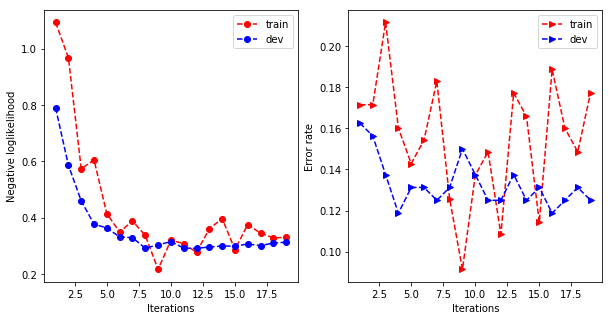

In [166]:
dev_score = dev_sample.map(score_clean)
eta0 = 0.1
l2 = 0.05
max_iter = 20
relax, beta = score_logit_sgd(eta0, l2, max_iter, dev_score, dev_size)
plt_iterations(relax, beta)
relax = np.array(relax)



In [167]:
regulation = []
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.81927925844729288, 0.19736842105263158, 0.69013425584422661, 0.16875]
[2, 0.50526253266812637, 0.1513157894736842, 0.57407932047026333, 0.14375]
[3, 0.6720723576967963, 0.1513157894736842, 0.49748428271457285, 0.14375]
[4, 0.6249784934622723, 0.17763157894736842, 0.42196164532986291, 0.15625]
[5, 0.53201808207236512, 0.17763157894736842, 0.37981026812406177, 0.1375]
[6, 0.5457182515238802, 0.21052631578947367, 0.35432552774038995, 0.13125]
[7, 0.54035395609974135, 0.19736842105263158, 0.33012376319510905, 0.11875]
[8, 0.58341950874570447, 0.20394736842105263, 0.31612135052676799, 0.1375]
[9, 0.43878344755861454, 0.17105263157894737, 0.30911252299300329, 0.1125]
[10, 0.39737118723513032, 0.13815789473684212, 0.30513202931123284, 0.125]
[11, 0.40887735558702998, 0.14473684210526316, 0.29860288731213169, 0.13125]
[12, 0.39300425629653885, 0.17763157894736842, 0.29185462470132956, 0.11875]

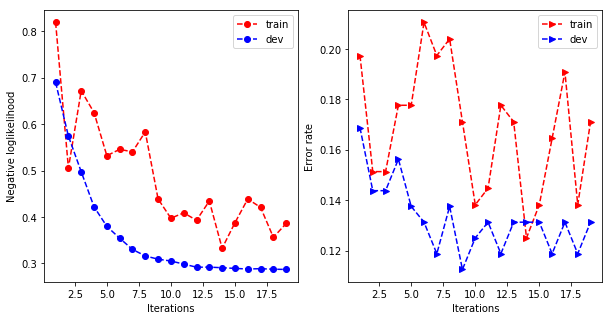

In [168]:
eta0 = 0.1
l2 = 0.005
max_iter = 20
relax, beta = score_logit_sgd(eta0, l2, max_iter, dev_score, dev_size)
plt_iterations(relax, beta)
relax = np.array(relax)
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.41419311708927081, 0.1503267973856209, 0.54701816322612529, 0.15]
[2, 1.6632121678682892, 0.4444444444444444, 1.1129491704217549, 0.3125]
[3, 0.46872469176581388, 0.1568627450980392, 0.33322079004300525, 0.13125]
[4, 0.7349127728628374, 0.2679738562091503, 0.77831120166520351, 0.31875]
[5, 0.34495710087146947, 0.13071895424836602, 0.35025121747249616, 0.1375]
[6, 1.5551666733649823, 0.5620915032679739, 0.91768670731697788, 0.375]
[7, 0.44011995670464871, 0.1503267973856209, 0.31226378266129817, 0.13125]
[8, 0.78739957036953356, 0.37254901960784315, 0.57483277958743417, 0.29375]
[9, 0.38363338548337672, 0.16993464052287582, 0.29427290390641098, 0.1375]
[10, 0.64374934116175075, 0.3006535947712418, 0.46806426960426889, 0.2375]
[11, 0.41006321059860579, 0.16339869281045752, 0.29248768478480469, 0.125]
[12, 0.71456937255281627, 0.3464052287581699, 0.54439737328868676, 0.3125]
[13, 0.376249

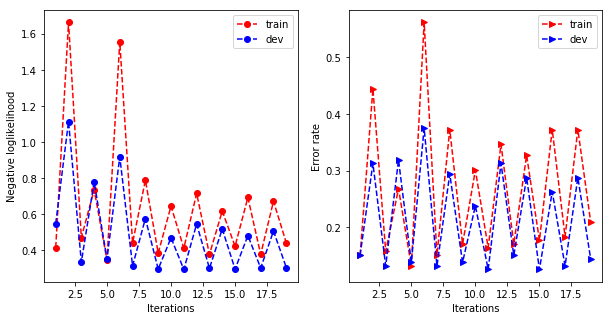

In [169]:
eta0 = 0.1
l2 = 0.2
max_iter = 20
relax, beta = score_logit_sgd(eta0, l2, max_iter, dev_score, dev_size)
plt_iterations(relax, beta)
relax = np.array(relax)
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())

Iteration#	neg_log_likelihood(train)	Error_rate(train)	neg_log_likelihood(dev)	Error_rate(dev)

[1, 0.81819660220285129, 0.14361702127659576, 0.91111917892842498, 0.18125]
[2, 0.56479069602026055, 0.14361702127659576, 0.79270083999112761, 0.15]
[3, 0.7127665287013828, 0.17553191489361702, 0.71204634636232367, 0.14375]
[4, 0.81866995308550361, 0.17553191489361702, 0.64436456208109782, 0.14375]
[5, 0.75236134982193603, 0.14893617021276595, 0.5814078196258381, 0.1375]
[6, 0.60587236669769862, 0.14361702127659576, 0.54757600024484032, 0.1375]
[7, 0.54393827586782506, 0.10638297872340426, 0.52123198742228394, 0.1375]
[8, 0.59521696393094314, 0.13297872340425532, 0.47113599705611253, 0.13125]
[9, 0.57707905800973791, 0.14361702127659576, 0.44608202787531626, 0.13125]
[10, 0.56295930982952325, 0.16489361702127658, 0.41900693295780594, 0.13125]
[11, 0.23009698958555946, 0.09042553191489362, 0.41130458811719156, 0.13125]
[12, 0.72357701137027142, 0.16489361702127658, 0.38330278448370292, 0.1312

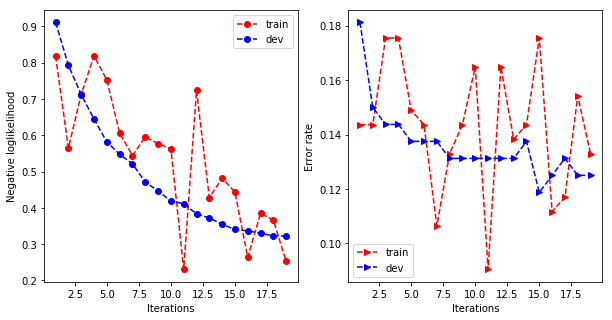

In [179]:
eta0 = 0.1
l2 = 0.0005
max_iter = 20
relax, beta = score_logit_sgd(eta0, l2, max_iter, dev_score, dev_size)
plt_iterations(relax, beta)
relax = np.array(relax)
regulation.append([l2] + np.mean(relax[13:, [2,4]], axis=0).tolist())

lambda, error rate for training date, error rate for develop data:
[0.05, 0.15904761904761905, 0.12604166666666666]
[0.005, 0.15460526315789475, 0.12708333333333333]
[0.2, 0.27342047930283225, 0.20625000000000002]
[0.0005, 0.13918439716312056, 0.12708333333333333]


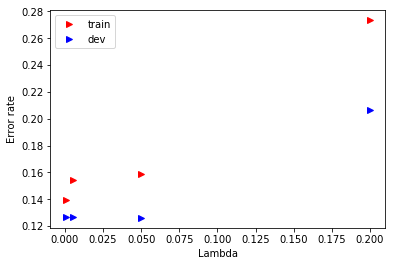

In [180]:
print 'lambda, error rate for training date, error rate for develop data:'
for line in regulation:
    print line
plot_lambda(regulation)

In [181]:
test_score = test_sample.map(score_clean)
ans = get_error_rate(test_score, beta, test_size)
print 'The error rate of test set is %.02f' % ans[1]

The error rate of test set is 0.15



By analyzing the scores of the appearance, aroma, palate, style, taste of a beer, we build a logistic classifier, which gives the optimal error rate of dev data set around 13% and test data set of 15%. This score model works better than the model constructed by text (29%). This is because quantitative numbers is more informative than texts. Text may contain ambiguous expressions or even sarcasm, which are difficult for computers to identify.

# SVM classifer

In [197]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

def score_svm_clean(x):
    # Normalize the data for each feature by (x-mean)/std
    label = binary_label(x['overall'])
    features =  np.array([x['appearance'], x['aroma'], x['palate'], x['style'], x['taste']])
    for idx in range(len(features)):
        features[idx] = (features[idx] - means[idx]) / stds[idx]
    return LabeledPoint(label, features)

def score_svm_sgd(l2_list):
    # Perform SGD SVM regression
    train_sample = train.sample(False, 5 * 1e-4)
    dev_lf = dev_sample.map(score_svm_clean)
    batch_df = train_sample.map(score_svm_clean)
    train_errors = []
    dev_errors = []
    models = []
    for l2 in l2_list:
        model = SVMWithSGD.train(batch_df, iterations=100, regParam = l2)
        labelsAndPreds = batch_df.map(lambda p: (p.label, model.predict(p.features)))
        trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(batch_df.count())
        labelsAndPreds = dev_lf.map(lambda p: (p.label, model.predict(p.features)))
        devErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(dev_lf.count())
        print("l2 = " + str(l2) + "\tTraining Error = " + str(trainErr) + "\tDev Error = " + str(devErr))
        train_errors.append(trainErr)
        dev_errors.append(devErr)
        models.append(model)
    return l2_list, train_errors, dev_errors, models



In [199]:
l2_list = [0.0005, 0.005, 0.05, 0.2, 0.5]
l2, train_errors, dev_errors, models = score_svm_sgd(l2_list)

l2 = 0.0005	Training Error = 0.143867924528	Dev Error = 0.125
l2 = 0.005	Training Error = 0.143867924528	Dev Error = 0.125
l2 = 0.05	Training Error = 0.142688679245	Dev Error = 0.125
l2 = 0.2	Training Error = 0.145047169811	Dev Error = 0.13125
l2 = 0.5	Training Error = 0.142688679245	Dev Error = 0.1375


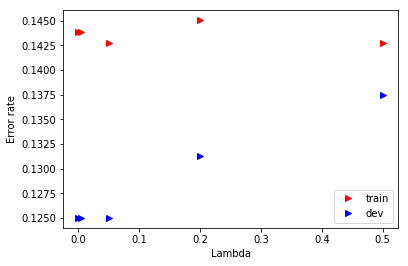

In [200]:
def plot_lambda_svm(lambdas, tr_error_rate, dev_error_rate):
    #plt.figure(figsize = (10, 5))
    #plt.subplot(1,2,1)
    plt.plot(lambdas, tr_error_rate, 'r>', label='train')
    plt.legend()
    #plt.subplot(1,2,2)
    plt.plot(lambdas, dev_error_rate, 'b>', label='dev')
    plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('Error rate')
    plt.show()   
plot_lambda_svm(l2, train_errors, dev_errors)

In [202]:
model_best = models[2]
test_svm = test_sample.map(score_svm_clean)
labelsAndPreds = test_svm.map(lambda p: (p.label, model_best.predict(p.features)))
testErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(test_svm.count())
print("\tTesting Error = " + str(trainErr))


	Testing Error = 0.166666666667


Here we use a SVM linear model to model the reviews, based on the scores. Our error rate on the testing data set is 16.6% with lamda = 0.05, which is very similar with the logistic model (15%).

In [207]:
df2 = spark.read.json('/project/cmsc25025/beer_review/unlabeled.json')
print type(df2)
df2.show()



<class 'pyspark.sql.dataframe.DataFrame'>
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|   2.0|On tap at the Spr...|        4|   33|  4.0|
|       4.0|  5.0|  19708|John Harvards Dr....|  3084|   4.0|From Springfield ...|       12|   60|  7.0|
|       3.0|  6.0|  21566|Barley Island Bar...|  1786|   3.0|GTMW 08 on cask -...|       19|   66|  6.0|
|       3.0|  7.0| 108906|Barley Island Dir...|  1786|   3.0|Handbottled, cour...|       25|   57|  7.0|
|       4.0|  7.0| 108906|Barley Island Dir...|  1786|   3.0|Bottled. Amber co...|       30|   57|  7.0|
|       3.0|  8.0| 108906|Barley Island Dir...|  1786|   4.0|Had this on tap l...|       35|   57|  9.0|
|       4.0| 

In [214]:
def score_unlabeled_clean(x):
    # Normalize the data for each feature by (x-mean)/std
    review_id = x['review_id']
    features =  np.array([x['appearance'], x['aroma'], x['palate'], x['style'], x['taste']])
    for idx in range(len(features)):
        features[idx] = (features[idx] - means[idx]) / stds[idx]
    return (review_id, LabeledPoint(0, features))
df_features = df2.rdd.map(score_unlabeled_clean)
predictions = df_features.map(lambda p: {p[0]: model_best.predict(p[1].features)}).reduce(lambda a, b: dict(a.items() + b.items()))
print predictions.items()[:10]
#with open('assn3_prob4_predict.json', 'w') as f:
#    json.dump(predictions, f)



[(2097152, 1), (4, 0), (699052, 1), (1048586, 0), (12, 1), (1048589, 0), (1048592, 0), (1048594, 0), (19, 0), (1747630, 0)]


In [216]:
with open('assn3_prob4_predict.json', 'w') as f:
    json.dump(predictions, f)

In [ ]:
spark.stop()